# benchmark.ipynb
## Benchmark Testing Using AUC - ROC Curves
### Purpose
The purpose of this notebook is to explore testing the ML algorithms written in this repo and their scores on a standard benchmark. This will help us identify what is the "best" algorithm to use for this specific kind of data analysis.

With reference to some resources, we can approach creating scripts to test various ML algorithms given that we feed them the same data set.

Reference:
https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc

"The **receiver-operating characteristic curve (ROC)** is a visual representation of model performance across all thresholds." We can draw this curve by calculating the **true positive rate (TPR)** and **false positive rate (FPR)** at every possible threshold, then graphing TPR over FPR.
+ A perfect model will have, at some threshold, a TPR of 1.0 and a FPR of 0.0.
+ A perfect model can be represented by either a point (0,1) if all other thresholds are ignored.

"The **area under the ROC curve (AUC)** represents the probability that the model, if given a randomly-chosen positive and negative example, will rank the positive higher than the negative."
+ A perfect model will have a 100% probability of ranking a randomly-chosen positive example higher than a randomly-chosen negative example.

AUC is a useful tool to compare the performance of two different models, as long as the **dataset is roughly balanced**.
+ Generally, **the model with the greatest area under the curve is the better one**.

Reference:
https://en.wikipedia.org/wiki/Receiver_operating_characteristic

The AUC - ROC curve is used solely for **binary classifier models** and **multi-class classification** models. The thresholds are the main contributors to the determination of the area under the curve.

With reference to statistics, we can think of the AUC - ROC curve as **a plot of the statistical power as a fucntion of the Type I error of the decision rule.
+ The ROC curve is just the sensitivity as a function of false positive rate.

The ROC curve, then, is just the cumulative distribution function (CDF) of the detection probability in the y-axis versus the CDF of the false positive probability on the x-axis.

With this in mind, we can now work to create scripts to create and show this curve for various fed models.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold
import seaborn as sns

def evaluate_model_auc_roc(model, X_test, y_test, model_name="Model", plot=True):
    """
    Evaluate a binary classification model using AUC-ROC metrics
    
    Parameters:
    -----------
    model : trained model object
        Must have predict_proba method
    X_test : array-like
        Test features
    y_test : array-like
        True test labels
    model_name : str
        Name for the model (used in plots)
    plot : bool
        Whether to generate ROC curve plot
    
    Returns:
    --------
    dict : Dictionary containing evaluation metrics
    """
    
    # Get prediction probabilities
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test)[:, 1]  # Probability of positive class
    else:
        raise ValueError("Model must have predict_proba method for AUC-ROC calculation")
    
    # Get binary predictions
    y_pred = model.predict(X_test)
    
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    
    # Alternative AUC calculation (should be the same)
    roc_auc_sklearn = roc_auc_score(y_test, y_proba)
    
    # Print results
    print(f"=== {model_name} AUC-ROC Evaluation ===")
    print(f"AUC-ROC Score: {roc_auc:.4f}")
    print(f"AUC-ROC (sklearn): {roc_auc_sklearn:.4f}")
    
    # Classification report
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"\nConfusion Matrix:")
    print(cm)
    
    if plot:
        # Create subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        
        # ROC Curve
        ax1.plot(fpr, tpr, color='darkorange', lw=2, 
                label=f'ROC curve (AUC = {roc_auc:.4f})')
        ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
                label='Random Classifier')
        ax1.set_xlim([0.0, 1.0])
        ax1.set_ylim([0.0, 1.05])
        ax1.set_xlabel('False Positive Rate')
        ax1.set_ylabel('True Positive Rate')
        ax1.set_title(f'{model_name} - ROC Curve')
        ax1.legend(loc="lower right")
        ax1.grid(True, alpha=0.3)
        
        # Confusion Matrix Heatmap
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax2)
        ax2.set_title(f'{model_name} - Confusion Matrix')
        ax2.set_ylabel('True Label')
        ax2.set_xlabel('Predicted Label')
        
        plt.tight_layout()
        plt.show()
    
    # Return metrics dictionary
    return {
        'auc_roc': roc_auc,
        'fpr': fpr,
        'tpr': tpr,
        'thresholds': thresholds,
        'confusion_matrix': cm,
        'y_pred': y_pred,
        'y_proba': y_proba
    }

def cross_validate_auc_roc(model, X, y, cv_folds=5, model_name="Model"):
    """
    Perform cross-validation with AUC-ROC scoring
    
    Parameters:
    -----------
    model : sklearn model object
        Untrained model
    X : array-like
        Features
    y : array-like
        Labels
    cv_folds : int
        Number of cross-validation folds
    model_name : str
        Name for the model
    
    Returns:
    --------
    dict : Cross-validation results
    """
    
    print(f"=== {model_name} Cross-Validation AUC-ROC ===")
    
    # Stratified K-Fold to maintain class balance
    skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
    
    # Cross-validation with AUC scoring
    cv_scores = cross_val_score(model, X, y, cv=skf, scoring='roc_auc')
    
    print(f"Cross-Validation AUC-ROC Scores: {cv_scores}")
    print(f"Mean AUC-ROC: {cv_scores.mean():.4f}")
    print(f"Standard Deviation: {cv_scores.std():.4f}")
    print(f"95% Confidence Interval: {cv_scores.mean():.4f} ± {1.96 * cv_scores.std():.4f}")
    
    return {
        'cv_scores': cv_scores,
        'mean_auc': cv_scores.mean(),
        'std_auc': cv_scores.std()
    }

def load_and_evaluate_pickled_model(model_path, X_test, y_test, model_name="Pickled Model"):
    """
    Load a pickled model and evaluate it with AUC-ROC
    
    Parameters:
    -----------
    model_path : str
        Path to the pickled model file
    X_test : array-like
        Test features
    y_test : array-like
        Test labels
    model_name : str
        Name for the model
    
    Returns:
    --------
    dict : Evaluation results
    """
    
    try:
        with open(model_path, 'rb') as f:
            model = pickle.load(f)
        
        print(f"Successfully loaded model from {model_path}")
        
        # Evaluate the model
        results = evaluate_model_auc_roc(model, X_test, y_test, model_name)
        
        return results
        
    except Exception as e:
        print(f"Error loading model from {model_path}: {e}")
        return None

def benchmark_multiple_models(models_dict, X_test, y_test, plot_comparison=True):
    """
    Compare multiple models using AUC-ROC
    
    Parameters:
    -----------
    models_dict : dict
        Dictionary with model_name: model_object pairs
    X_test : array-like
        Test features
    y_test : array-like
        Test labels
    plot_comparison : bool
        Whether to create comparison plot
    
    Returns:
    --------
    dict : Results for all models
    """
    
    results = {}
    
    if plot_comparison:
        plt.figure(figsize=(10, 8))
    
    for model_name, model in models_dict.items():
        print(f"\n{'='*50}")
        result = evaluate_model_auc_roc(model, X_test, y_test, model_name, plot=False)
        results[model_name] = result
        
        if plot_comparison:
            plt.plot(result['fpr'], result['tpr'], lw=2, 
                    label=f'{model_name} (AUC = {result["auc_roc"]:.4f})')
    
    if plot_comparison:
        plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves Comparison')
        plt.legend(loc="lower right")
        plt.grid(True, alpha=0.3)
        plt.show()
    
    # Summary table
    print(f"\n{'='*50}")
    print("SUMMARY - AUC-ROC Comparison")
    print(f"{'='*50}")
    for model_name, result in results.items():
        print(f"{model_name:20s}: AUC = {result['auc_roc']:.4f}")
    
    return results

# Example usage functions
def example_with_trained_model(trained_model, X_test, y_test):
    """Example of how to use with your trained model"""
    return evaluate_model_auc_roc(trained_model, X_test, y_test, "RandomForest")

def example_with_pickled_model(X_test, y_test):
    """Example of how to use with your pickled RandomForest model"""
    return load_and_evaluate_pickled_model('RandomForest_model.pkl', X_test, y_test, "RandomForest")

def example_cross_validation(X_train, y_train):
    """Example of cross-validation with your model type"""
    from sklearn.ensemble import RandomForestClassifier
    
    model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
    return cross_validate_auc_roc(model, X_train, y_train, cv_folds=5, model_name="RandomForest")

# Interpretation guide
def interpret_auc_roc_score(auc_score):
    """
    Provide interpretation of AUC-ROC score
    """
    print(f"\n=== AUC-ROC Score Interpretation ===")
    print(f"Your AUC-ROC Score: {auc_score:.4f}")
    
    if auc_score >= 0.9:
        interpretation = "Excellent"
    elif auc_score >= 0.8:
        interpretation = "Good"
    elif auc_score >= 0.7:
        interpretation = "Fair"
    elif auc_score >= 0.6:
        interpretation = "Poor"
    else:
        interpretation = "Very Poor (worse than random)"
    
    print(f"Interpretation: {interpretation}")
    print(f"""
    AUC-ROC Interpretation Guide:
    - 1.0: Perfect classifier
    - 0.9-1.0: Excellent
    - 0.8-0.9: Good  
    - 0.7-0.8: Fair
    - 0.6-0.7: Poor
    - 0.5-0.6: Very Poor
    - 0.5: Random classifier (no discriminative ability)
    - <0.5: Worse than random (but can be inverted)
    """)

=== TRAINING ML MODEL (MATCHED TO PREDICTION) ===
Target channels: ['Height', 'Amplitude', 'Phase', 'ZSensor']
Expected features: 4 channels * 4 stats + 6 pairs = 22
Found 58 good image files
Found 14 bad image files
Feature names (22): ['Amplitude_std', 'Amplitude_range', 'Amplitude_entropy', 'Amplitude_skew', 'Height_std', 'Height_range', 'Height_entropy', 'Height_skew', 'Phase_std', 'Phase_range', 'Phase_entropy', 'Phase_skew', 'ZSensor_std', 'ZSensor_range', 'ZSensor_entropy', 'ZSensor_skew', 'Amplitude_Height_residual', 'Amplitude_Phase_residual', 'Amplitude_ZSensor_residual', 'Height_Phase_residual', 'Height_ZSensor_residual', 'Phase_ZSensor_residual']
Successfully processed 58 good images
Successfully processed 14 bad images
Final training data: 72 samples, 22 features
Good images: 58, Bad images: 14
Training accuracy: 1.000
Test accuracy: 1.000
Cross-validation score: 0.876 (+/- 0.094)

Top 10 Most Important Features:
            feature  importance
0     Amplitude_std    0.132

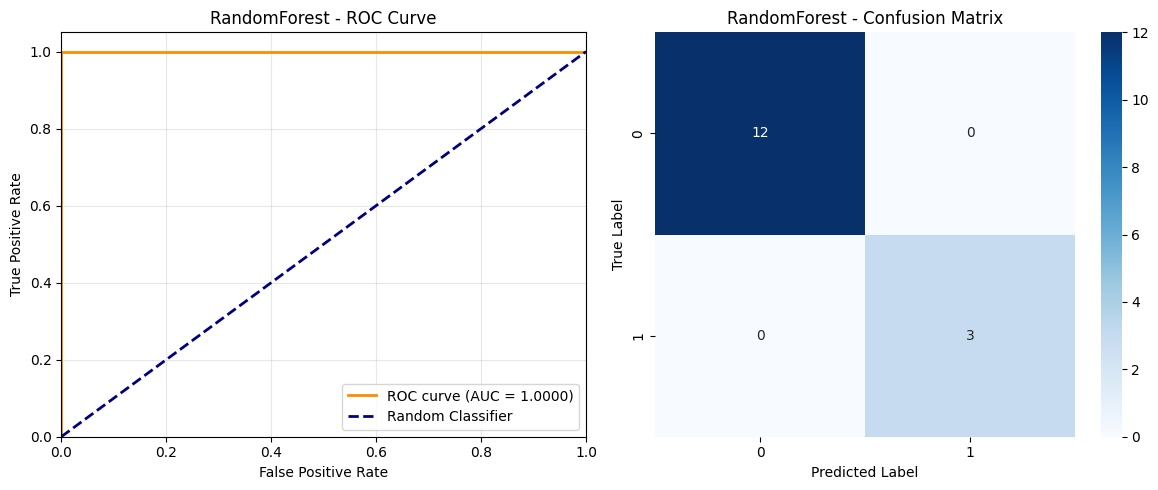

In [ ]:
# After training your model with train_ml_model_matched()
from utils import train_ml_model_matched
from aespm import ibw_read

bad_image_files = 'sorted_data/bad_images'
good_image_files = 'sorted_data/good_images'

# Train the model
results = train_ml_model_matched(bad_image_files, good_image_files, ibw_read)
auc_results = evaluate_model_auc_roc(
    results['model'], 
    results['X_test'], 
    results['y_test'], 
    "RandomForest"
)